In [1]:
import jax
import jax.numpy as jnp
from jax import random

from flax import nnx

from matplotlib import colors, pyplot as plt
import os

from clu import metric_writers

import dataclasses

2025-08-28 15:55:48.974319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756389348.994688 2865134 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756389349.000863 2865134 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756389349.017026 2865134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756389349.017042 2865134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756389349.017044 2865134 computation_placer.cc:177] computation placer alr

In [2]:
import numpy as np
from jax.tree_util import tree_map

In [3]:
jax.devices()

[CpuDevice(id=0)]

In [4]:
logdir = '../metrics'

# Input model

We consider an input that evolves as an AR(1) model:
$$
S_t = \phi S_{t-1} + \sigma\xi_t
$$
where $\xi_t$ are iid random variables from a unit Gaussian distribution, and $\phi, \sigma$ are real parameters. The autocovariance is given by
$$
\langle S_{\tau} S_{\tau + t} \rangle = \frac{\sigma^2}{1 - \phi^2} \phi^{|t|}
$$

In [5]:
class InputModel(nnx.Module):
    def __init__(self, phi=0.5, sigma=1.0, rngs = None):
        self.phi = phi
        self.sigma = sigma
        self.rngs = rngs
    
    def __call__(self, s, generate=False, rngs=None):
        phi = self.phi
        sigma = self.sigma
        std = jnp.sqrt(sigma**2 / (1 - phi**2))

        rng = self.rngs['input'] if rngs is None else rngs

        def step(carry, s):
            key, logp, s_prev = carry
            if generate:
                key, next_key = random.split(key)
                s = phi * s_prev + sigma * random.normal(key, s.shape)
            else:
                next_key = None
            logp += jax.scipy.stats.norm.logpdf(s - phi * s_prev, scale=sigma)
            return (next_key, logp, s), (s if generate else None)

        if generate:
            s0 = random.normal(rng(), s.shape[:-1]) * std
            key = rng()
        else:
            s0 = s[...,0]
            key = None

        logp_init = jax.scipy.stats.norm.logpdf(s0, scale=std)

        (_, logp, _), traj = jax.lax.scan(step, (key, logp_init, s0), s[...,1:].T)

        if generate:
            return logp, jnp.concatenate((jnp.expand_dims(s0, -1), traj.T), axis=-1)
        else:
            return logp

In [6]:
key = random.PRNGKey(42)
s_key, x_key = random.split(key)

In [7]:
s_model = InputModel(rngs=nnx.Rngs(input=s_key))
s_model

InputModel( # RngState: 2 (12 B)
  phi=0.5,
  sigma=1.0,
  rngs=Rngs( # RngState: 2 (12 B)
    input=RngStream( # RngState: 2 (12 B)
      key=RngKey( # 1 (8 B)
        value=Array((), dtype=key<fry>) overlaying:
        [1832780943  270669613],
        tag="'input'"
      ),
      count=RngCount( # 1 (4 B)
        value=Array(0, dtype=uint32),
        tag="'input'"
      )
    )
  )
)

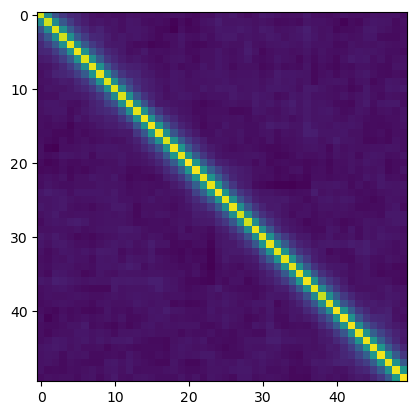

In [8]:
_, s_data = s_model(jnp.empty((5000, 50)), generate=True)
plt.imshow(jnp.cov(s_data.T))
del s_data

In [9]:
def ar_cov(t, phi, sigma):
    return sigma**2 / (1.0 - phi**2) * phi**(jnp.abs(t))

In [10]:
t = jnp.arange(0, 50)

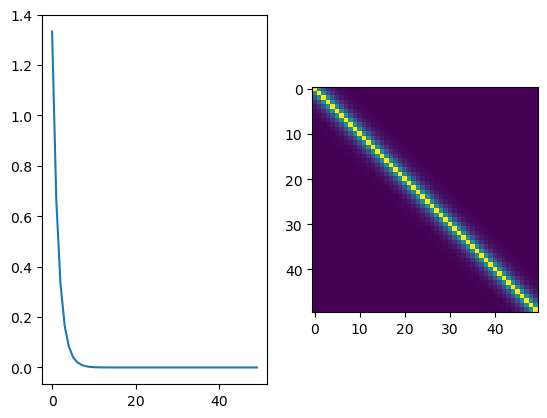

In [11]:
s_cov = ar_cov(t, s_model.phi, s_model.sigma)
s_cov_mat = jax.scipy.linalg.toeplitz(s_cov, s_cov)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(s_cov)
ax2.imshow(s_cov_mat)

In [12]:
s_probs, epsilon = s_model(jnp.zeros((1000, 50)), generate=True, rngs=nnx.Rngs(s_key))
s_probs.shape, epsilon.shape

((1000,), (1000, 50))

# Output Model

The output is generated via a nonlinear function applied to the input, plus independent noise.

$$
X_t = f(S_t) + \rho X_{t-1} + \theta \eta_t
$$

To compute the log-probability $\ln P(\mathbf{x}|\mathbf{s})$ we invert the process.

$$
\eta_t = \frac{1}{\theta} (X_t - \rho X_{t-1} - f(S_t))
$$



In [13]:
from ml_pws.models.logistic_model import LogisticModel

logistic_model = LogisticModel(
    gain=1.0,
    decay=0.2,
    noise=0.2,
)
logistic_model

LogisticModel(
  cell=LogisticCell(
    gain=1.0,
    decay=0.2,
    noise=0.2
  ),
  rngs=None
)

The potential of $s$ is defined as
$$
U_n(s) = - \ln P(s) - \ln P(x_{0:n}|s) = -\ln P(s, x_{0:n})
$$
where $x_{0:n}$ is the partial $x$ trajectory from $0$ to $n$.

To compute the mutual information we need to compute the log-ratio
$$
\ln\frac{P(s, x_{0:n})}{P(s)P(x_{0:n})} = -U_n(s) - \ln P(s) - \ln\int ds\ e^{-U_n(s)}
$$

In [14]:
_, x = logistic_model(epsilon, jnp.zeros_like(epsilon), generate=True, rngs=nnx.Rngs(generate=x_key))
x.shape

(1000, 50)

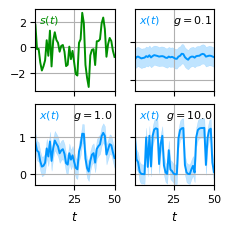

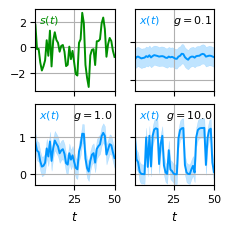

In [15]:
test_s = epsilon[1]
time = np.arange(1,51)
plt.style.use('seaborn-v0_8-paper')
with plt.rc_context({'font.size': 8}):
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(158 / 72, 160 / 72))
    axs[0,0].plot(time, test_s, color='#008F00')
    axs[0,0].text(0.05, 0.95, '$s(t)$', fontsize=8, transform=axs[0,0].transAxes, verticalalignment='top', color='#008F00')
    axs[0,0].set_yticks([-2, 0, 2])
    for i in [0,1]:
        axs[0,i].set_xticklabels([])
        axs[i,1].set_yticklabels([])
        axs[1,i].set_xlabel('$t$')
    for ax in axs.reshape(-1):
        ax.grid(visible=True)
        ax.set_xlim(1,50)
        ax.tick_params(axis='both', which='major', pad=3)
    for gain, coord in zip([0.1, 1.0, 10.0], [(0, 1), (1, 0), (1, 1)]):
        axs[coord].text(0.05, 0.95, f'$x(t)$', transform=axs[coord].transAxes, fontsize=8, verticalalignment='top', horizontalalignment='left', color='#0096FF')
        axs[coord].text(0.98, 0.95, f'$g = {gain}$', transform=axs[coord].transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right')
        var_model = LogisticModel(gain=gain, decay=0.2, noise=0.2)
        _, test_x = var_model(jnp.tile(test_s, (10_000, 1)), jnp.empty((10_000, test_s.shape[0])), generate=True, rngs=nnx.Rngs(generate=x_key))
        q10 = jnp.percentile(test_x, 10, axis=0)
        q90 = jnp.percentile(test_x, 90, axis=0)
        axs[coord].plot(time, jnp.mean(test_x, axis=0), color='#0096FF')
        axs[coord].fill_between(time, q10, q90, alpha=0.25, color='#0096FF')
        # axs[coord].set_title(f"output (g = {gain})", fontsize=8)
        axs[coord].set_ylim(-0.3, 1.9)

fig.savefig('../reports/figures/input_output.pdf')
fig

# VI

First we define a variational model based on a recurrent neural network.

First we define a regular RNN (with a GRU cell):

## Variational RNN

In [ ]:
from ml_pws.models.variational_rnn import VariationalRnn

var_rnn_model = VariationalRnn(64, 5, 1, nnx.Rngs(0))
logp, preds = var_rnn_model(epsilon, x)
logp.shape, preds.shape

((1000, 50), (1000, 50))

## Inverse Autoregressive Flow

## Training loop

In [17]:
model_dim = 16
variational_model = VariationalRnn(model_dim, 2, 1, nnx.Rngs(0))
# variational_model = IAF(9, model_dim, 8, rngs=nnx.Rngs(0))
variational_model

VariationalRnn( # Param: 2,514 (10.1 KB)
  decoder_rnn=RNN( # Param: 2,514 (10.1 KB)
    broadcast_rngs=None,
    cell=FlowRNNCell( # Param: 2,514 (10.1 KB)
      cell=LSTMCell( # Param: 2,176 (8.7 KB)
        activation_fn=<PjitFunction of <function tanh at 0x7fb021bee2a0>>,
        bias_init=<function zeros at 0x7fb0219cfec0>,
        carry_init=<function zeros at 0x7fb0219cfec0>,
        dtype=None,
        gate_fn=<PjitFunction of <function sigmoid at 0x7fb02186ade0>>,
        hf=Linear( # Param: 272 (1.1 KB)
          bias=Param( # 16 (64 B)
            value=Array(shape=(1, 16), dtype=dtype('float32'))
          ),
          bias_init=<function zeros at 0x7fb0219cfec0>,
          dot_general=<function dot_general at 0x7fb021ed4cc0>,
          dtype=None,
          in_features=16,
          kernel=Param( # 256 (1.0 KB)
            value=Array(shape=(1, 16, 16), dtype=dtype('float32'))
          ),
          kernel_init=<function modified_orthogonal at 0x7fb020c79800>,
          ou

In [18]:
import optax

optimizer = nnx.Optimizer(variational_model, optax.adamw(1e-3))


def elbo_loss(variational_model, key, batch_size=32, subsample=1):
    s_key, x_key, elbo_key = random.split(key, 3)
    _, s = s_model(jnp.empty((batch_size, 50)), generate=True, rngs=nnx.Rngs(s_key))
    _, x = logistic_model(s, jnp.empty_like(s), generate=True, rngs=nnx.Rngs(x_key))

    state_axes = nnx.StateAxes({...: None})

    @nnx.split_rngs(splits=subsample)
    @nnx.vmap(in_axes=(state_axes, 0))
    def elbo_sample(variational_model, subkey):
        _, s = s_model(jnp.empty_like(x), generate=True, rngs=nnx.Rngs(subkey))
        kl_div, preds = variational_model(s, x)
        log_cond = logistic_model(preds, x)
        return (log_cond, kl_div)

    log_cond, kl_div = elbo_sample(
        variational_model, jax.random.split(elbo_key, subsample)
    )
    loss = -jnp.mean(log_cond - kl_div)
    log_likelihood = jnp.mean(log_cond)
    kl_div = jnp.mean(kl_div)
    return loss, {
        "loss": loss,
        "log_likelihood": log_likelihood,
        "kl_div": kl_div,
    }


writer = metric_writers.create_default_writer(os.path.join(logdir, "VAE"))

loss, metrics = elbo_loss(variational_model, key, batch_size=1024, subsample=8)
writer.write_scalars(0, metrics)
loss, metrics

2025-08-27 21:38:23.111475: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(Array(5.0050707, dtype=float32),
 {'loss': Array(5.0050707, dtype=float32),
  'log_likelihood': Array(-5.2603827, dtype=float32),
  'kl_div': Array(-0.25531018, dtype=float32)})

In [ ]:
@nnx.jit
def train_step(variational_model, optimizer, key):
    grad_fn = nnx.value_and_grad(elbo_loss, argnums=0, has_aux=True)
    (loss, metrics), grads = grad_fn(variational_model, key, 1024, 8)
    optimizer.update(grads)
    return loss, metrics

num_epochs = 200
for epoch in range(num_epochs):
    epoch_key = jax.random.fold_in(key, optimizer.step.value)
    loss, metrics = train_step(variational_model, optimizer, epoch_key)
    writer.write_scalars(optimizer.step.value, metrics)

KeyboardInterrupt: 

## Evaluate

In [ ]:
def generate(var_model, x, N=1):
    _, s = s_model(jnp.empty((N,) + x.shape), generate=True, rngs=nnx.Rngs(1234))
    return var_model(s, jnp.repeat(jnp.expand_dims(x, 0), N, axis=0))

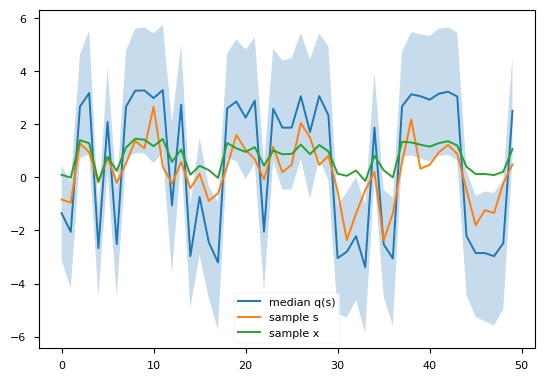

In [ ]:
i = 0

logp, preds = generate(variational_model, x[i], 10_000)
median = jnp.median(preds, axis=0)
q5 = jnp.percentile(preds, 5, axis=0)
q95 = jnp.percentile(preds, 95, axis=0)
plt.fill_between(range(preds.shape[1]), q5, q95, alpha=0.25)
plt.plot(median, label="median q(s)")
plt.plot(epsilon[i], label="sample s")
plt.plot(x[i], label="sample x")
plt.legend()

Now we want to compute the importance weights $P(s)P(x|s)/q(s|x)$ for trajectories sampled from $q(s|x)$.

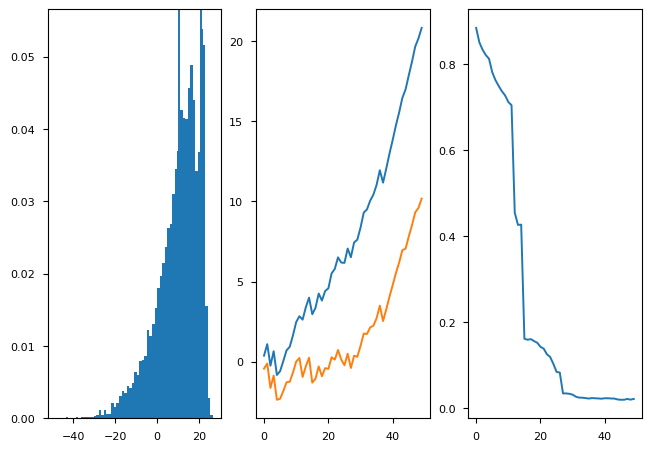

In [ ]:
logq_s, preds = generate(variational_model, x[i], 10_000)
logp_s = s_model(preds)
log_cond = logistic_model(preds, x[i])
log_weights = jnp.cumsum(- logq_s + log_cond, -1)
log_p_x_estimate = jax.nn.logsumexp(log_weights, 0) - jnp.log(log_weights.shape[0])
elbo = jnp.mean(log_weights, 0)
ess = 1 / jnp.sum(jax.nn.softmax(log_weights, 0)**2, 0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
ax1.hist(log_weights[:, -1], bins='auto', density=True)
ax1.axvline(log_p_x_estimate[-1])
ax1.axvline(elbo[-1])

ax2.plot(log_p_x_estimate)
ax2.plot(elbo)

ax3.plot(ess / preds.shape[0])

(Array(0.00010004, dtype=float32),
 Array(-256.88144, dtype=float32),
 Array(-106.0071, dtype=float32))

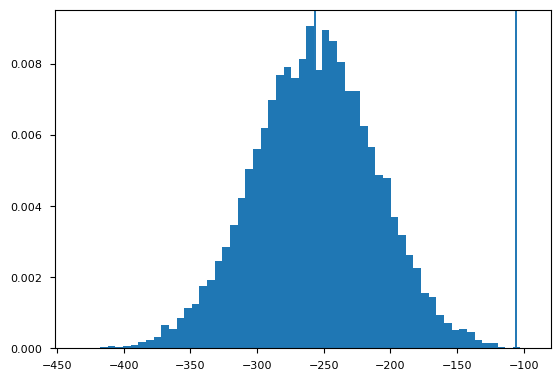

In [ ]:
_, prior_samples = s_model(jnp.empty((10_000, 50)), generate=True)
log_cond = logistic_model(prior_samples, x[i])
log_weights = jnp.sum(log_cond, -1)
log_p_x_estimate = jax.nn.logsumexp(log_weights) - jnp.log(log_cond.shape[0])
elbo = jnp.mean(log_weights)
ess = 1 / jnp.sum(jax.nn.softmax(log_weights)**2)
plt.hist(log_weights, bins='auto', density=True)
plt.axvline(log_p_x_estimate)
plt.axvline(elbo)
ess / prior_samples.shape[0], elbo, log_p_x_estimate

# AR Model

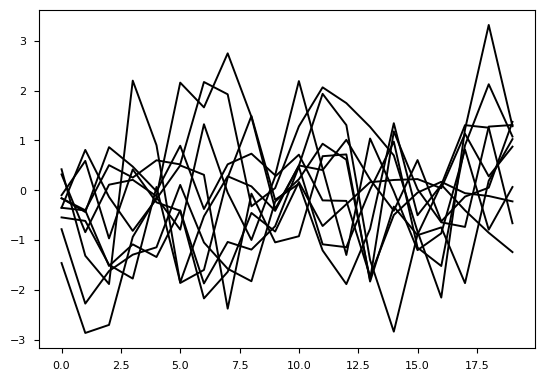

In [16]:
from ml_pws.models.ar_model import ARModel

ar_input = ARModel([0.5, -0.3, 0.2], 1.0, rngs=nnx.Rngs(0))
logp, s_out = ar_input(jnp.zeros((10, 20)), generate=True)
plt.plot(s_out.T, color='black');

# SMC

In [17]:
from ml_pws.models.variational_rnn import FlowRNNCell
from ml_pws.models.predictive_rnn import PredictiveCell
from ml_pws.models.smc_estimator import SMCEstimator

## Training Loop

In [18]:
def generate_data(N, length):
    _, s = ar_input(jnp.empty((N, length)), generate=True)
    _, x = logistic_model(s, jnp.empty_like(s), generate=True, rngs=nnx.Rngs(1))
    return s, x

train_s, train_x = generate_data(1000, 50)
val_s, val_x = generate_data(1000, 50)
train_s.shape, train_x.shape

((1000, 50), (1000, 50))

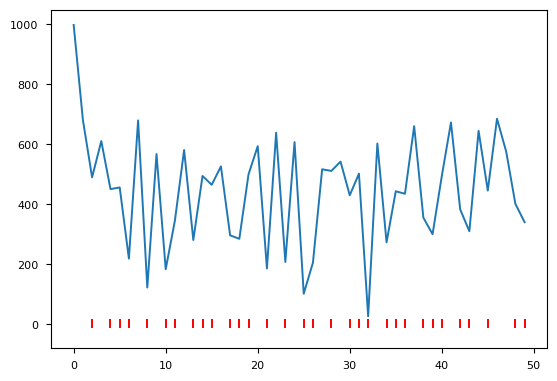

In [19]:
smc_estimator = SMCEstimator(ar_input.cell, FlowRNNCell(16, rngs=nnx.Rngs(0)), PredictiveCell(64, rngs=nnx.Rngs(2)), rngs=nnx.Rngs(1))
current_log_marginal, metrics = smc_estimator.log_marginal_estimate(train_x[0], n_particles=1024)
plt.plot(metrics.ess_values)
plt.eventplot(jnp.nonzero(metrics.resampling_flags), linelengths=30, color='red')

### Train Predictive (Forward) Model

In [21]:
from absl import logging
logging.set_verbosity("info")

In [20]:
from ml_pws.models.smc_estimator import train_forward_model
train_forward_model(smc_estimator, train_s, train_x)

epoch,loss,num_batches,batch_size
i64,f64,i64,i64
1,19.840225,32,32
2,-6.253993,32,32
3,-7.268808,32,32
4,-7.553037,32,32
5,-7.571125,32,32
…,…,…,…
96,-9.540848,32,32
97,-9.571744,32,32
98,-9.61066,32,32


### Train Variational (Inference) Model

In [22]:
from ml_pws.models.smc_estimator import train_backward_model
backward_log = train_backward_model(smc_estimator, train_x)

INFO:absl:[0] kl_div=0.17686189711093903, log_cond=-1.085763692855835, loss=1.2626254558563232
INFO:absl:[1] kl_div=0.1818884313106537, log_cond=-0.7948458194732666, loss=0.9767342805862427
INFO:absl:[2] kl_div=0.2712480127811432, log_cond=-0.6555511355400085, loss=0.9267991185188293
INFO:absl:[3] kl_div=0.27737894654273987, log_cond=-0.585606575012207, loss=0.8629854917526245
INFO:absl:[4] kl_div=0.2474740892648697, log_cond=-0.5589423179626465, loss=0.8064164519309998
INFO:absl:[5] kl_div=0.2146681398153305, log_cond=-0.5483183860778809, loss=0.762986421585083
INFO:absl:[6] kl_div=0.20993001759052277, log_cond=-0.5085450410842896, loss=0.7184749245643616
INFO:absl:[7] kl_div=0.2061397284269333, log_cond=-0.46789073944091797, loss=0.6740304231643677
INFO:absl:[8] kl_div=0.21508395671844482, log_cond=-0.41608482599258423, loss=0.6311687231063843
INFO:absl:[9] kl_div=0.24044394493103027, log_cond=-0.3501761257648468, loss=0.5906201004981995
INFO:absl:[10] kl_div=0.27892813086509705, log

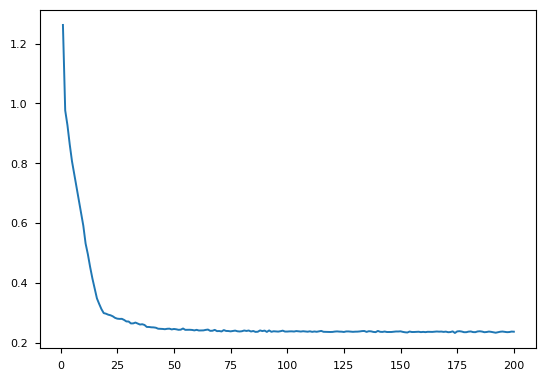

In [24]:
plt.plot(backward_log['epoch'], backward_log['loss'])

In [25]:
import polars as pl
from ml_pws.models.smc_estimator import estimate_mi

result = estimate_mi(smc_estimator, val_s, val_x)
result

ImportError: cannot import name 'estimate_mi' from 'ml_pws.models.smc_estimator' (/data/clusterusers/reinhardt/containerhome/ml-pws/ml_pws/models/smc_estimator.py)

In [31]:
aggregated_result = result.group_by("step", maintain_order=True).agg(
    (pl.col("log_conditional") - pl.col("log_marginal")).mean().alias("MutualInformation"),
    pl.col("ess").mean().alias("ESS"),
    pl.col("resample_flags").mean().alias('resample_fraction'),
)
aggregated_result.write_csv('../data/new_mlpws_estimate.csv')
aggregated_result

step,MutualInformation,ESS,resample_fraction
i64,f32,f32,f64
1,0.399465,497.924042,0.002
2,0.759844,438.755737,0.023
3,1.114968,396.867096,0.049
4,1.501082,374.234222,0.067
5,1.889843,354.410675,0.093
…,…,…,…
46,17.501009,349.016052,0.127
47,17.849483,352.046997,0.11
48,18.250195,350.303925,0.12


## Checks

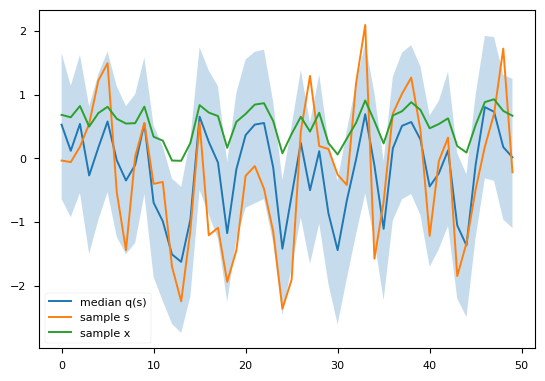

In [43]:
preds = smc_estimator.predict(val_x[0], 1000)
median = jnp.median(preds, axis=0)
q5 = jnp.percentile(preds, 5, axis=0)
q95 = jnp.percentile(preds, 95, axis=0)
plt.fill_between(range(preds.shape[1]), q5, q95, alpha=0.25)
plt.plot(median, label="median q(s)")
plt.plot(val_s[0], label="sample s")
plt.plot(val_x[0], label="sample x")
plt.legend()

# Gaussian Information

In [218]:
def cross_corr(data):
    N, L = data.shape[1:]
    result = jax.lax.conv(data, data, (1,), ((L, L),)) / N / L
    return jnp.arange(-L,L+1), jnp.transpose(result, (1,0,2))

def plot_cross_corr(data):
    lags, corr = cross_corr(data)
    plt.plot(lags, corr[0, 0], label="$\\langle s(t) s(t+\\Delta t)\\rangle$")
    plt.plot(lags, corr[0, 1], label="$\\langle s(t) x(t+\\Delta t)\\rangle$")
    plt.plot(lags, corr[1, 1], label="$\\langle x(t) x(t+\\Delta t)\\rangle$")
    plt.xlabel("$\\Delta t$")
    plt.grid()
    plt.legend()

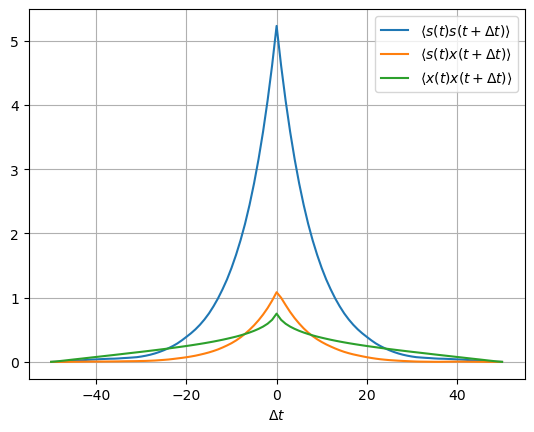

In [219]:
_, val_s = s_model(jnp.empty((2**12, 50)), generate=True)
_, val_x = logistic_model(val_s, jnp.empty_like(val_s), generate=True, rngs=nnx.Rngs(0))
plot_cross_corr(jnp.stack((val_s, val_x)))

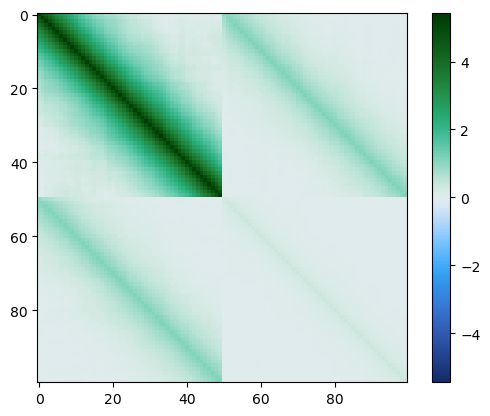

In [220]:
def plot_cov_matrix(input, output):
    data = jnp.concat((input.T, output.T), axis=0)
    plt.imshow(jnp.cov(data), norm=colors.CenteredNorm(), cmap=cc.m_CET_D13)
    plt.colorbar()
    
plot_cov_matrix(val_s, val_x)

In [41]:
def logdet_cholesky(matrix):
    L = jax.scipy.linalg.cholesky(matrix, lower=True)
    return 2.0 * jnp.sum(jnp.log(jnp.diag(L)))

@jax.jit
def gaussian_mi(s, x):
    s = s - jnp.mean(s)
    x = x - jnp.mean(x)
    L = s.shape[-1]
    data = jnp.concat((s.T, x.T), axis=0)
    cov_z = jnp.cov(data)
    cov_ss = cov_z[:L, :L]
    cov_xx = cov_z[L:, L:]

    logdet_ss = logdet_cholesky(cov_ss)
    logdet_xx = logdet_cholesky(cov_xx)
    logdet_z = logdet_cholesky(cov_z)
    
    return 0.5 * (logdet_ss + logdet_xx - logdet_z)

# Forward Model

## RNN model

In [79]:
class PredictiveCell(nnx.Module):
    def __init__(self, hidden_size: int, rngs: nnx.Rngs):
        self.rngs = rngs
        self.cell = GRUCell(2, hidden_size, rngs=rngs)
        self.dense = nnx.Linear(hidden_size, 2, rngs=rngs)
    
    def __call__(self, carry, s, x, generate=True):
        cell_state, last_prediction = carry
        if generate:
            x = jnp.expand_dims(last_prediction, -1)

        cell_state, y = self.cell(cell_state, jnp.concat((s, x), axis=-1))
        y = self.dense(y)
        mean, log_var = (jnp.squeeze(arr, -1) for arr in jnp.split(y, 2, axis=-1))

        if not generate:
            prediction = None
        else:
            rng = self.rngs['generate']
            prediction = mean + random.normal(rng(), shape=log_var.shape) * jnp.exp(log_var / 2)
        return (cell_state, prediction), ((mean, log_var), prediction)

    def initial_state(self, batch_size: int, generate=True):
        cell_state = self.cell.initial_state(batch_size)
        initial_prediction = jnp.zeros(batch_size) if generate else None
        return (cell_state, initial_prediction)
    

class Sequence(nnx.Module):
    def __init__(self, hidden_size: int, rngs: nnx.Rngs):
        self.cell = PredictiveCell(hidden_size, rngs)

    def __call__(self, s, x, generate=False):
        s = jnp.expand_dims(s, -1)
        x = jnp.expand_dims(x, -1)

        if not generate:
            target = jnp.squeeze(x, -1)
            x = shift_right(x, -2)

        s, x = jnp.broadcast_arrays(s, x)

        scan_fn = lambda carry, cell, s, x: cell(carry, s, x, generate)
        carry = self.cell.initial_state(x.shape[0], generate)
        carry, ((mean, log_var), preds) = nnx.scan(
            scan_fn, state_axes={},
            in_axes=-2, out_axes=-1,
        )(carry, self.cell, s, x)

        if generate:
            target = preds

        logp = jnp.sum(jax.scipy.stats.norm.logpdf(target, loc=mean, scale=jnp.exp(log_var / 2)), axis=-1)
        if generate:
            return logp, preds
        else:
            return logp

In [ ]:
var_model = Sequence(hidden_size=16, rngs=nnx.Rngs(x_key))
var_model(epsilon, x).shape

NameError: name 'GRUCell' is not defined

## Convolutional Model

In [ ]:
class ConvolutionalAutoregressiveModel(nnx.Module):
    def __init__(self, kernel_size: int,  hidden_features: int, num_layers: int, rngs: nnx.Rngs):
        self.layers = [
            nnx.Conv(
                in_features = (2 if i==0 else hidden_features),
                out_features = hidden_features,
                kernel_size = kernel_size,
                padding = 'CAUSAL',
                rngs=rngs
            )
            for i in range(num_layers)
        ]
        self.loc = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.log_scale = nnx.Linear(in_features=hidden_features, out_features=1, rngs=rngs)
        self.rngs = rngs

    def forward(self, s, x):
        z = jnp.concat((s, x), axis=-1)
        for conv in self.layers:
            z = jax.nn.relu(conv(z))
        loc = self.loc(z)
        log_scale = self.log_scale(z)
        return loc, log_scale

    def __call__(self, s, x, generate=False):
        s = jnp.expand_dims(s, -1)

        if generate:
            x = jnp.zeros(x.shape + (1,))
        else:
            x = jnp.expand_dims(x, -1)
            target = x
            x = shift_right(x, -2)

        s, x = jnp.broadcast_arrays(s, x)

        def step(pred, mod, i):
            loc, log_scale = mod.forward(s, shift_right(pred, -2))
            key = mod.rngs()
            loc = loc[...,i,:]
            log_scale = log_scale[...,i,:]
            eps = loc + jax.random.normal(key, loc.shape) * jnp.exp(log_scale)
            pred = pred.at[...,i,:].set(eps)
            return pred, (loc, log_scale)

        if generate:
            pred, (loc, log_scale) = nnx.scan(step, state_axes={}, out_axes=-2)(x, self, jnp.arange(x.shape[-2]))
            target = pred
        else:
            loc, log_scale = self.forward(s, x)

        logp = jnp.sum(jnp.squeeze(jax.scipy.stats.norm.logpdf(target, loc, jnp.exp(log_scale)), axis=-1), axis=-1)
        
        if generate:
            return logp, jnp.squeeze(pred, -1)
        else:
            return logp

var_model = ConvolutionalAutoregressiveModel(1, 16, 8, rngs=nnx.Rngs(0))
var_model(epsilon, x).shape

(1000,)

## Training Loop

In [ ]:
import optax

optimizer = nnx.Optimizer(var_model, optax.adam(1e-3))

forward_writer = metric_writers.create_default_writer(os.path.join(logdir, 'Forward'))

def forward_loss(model, s, x):
    log_likelihood = model(s, x)
    loss = -jnp.mean(log_likelihood)
    kl_div = jnp.mean(logistic_model(s, x) - log_likelihood)
    return loss, {'loss': loss, 'kl_div': kl_div}

loss, metrics = forward_loss(var_model, epsilon, x)
forward_writer.write_scalars(0, metrics)
loss

I0000 00:00:1719579330.115225  478462 cuda_executor.cc:989] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
W0000 00:00:1719579330.140225  478462 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Array(63.51897, dtype=float32)

In [84]:
@nnx.jit
def train_step(model, optimizer, s_batch, x_batch):
    grad_fn = nnx.value_and_grad(forward_loss, has_aux=True)
    (loss, metrics), grads = grad_fn(model, s_batch, x_batch)
    optimizer.update(grads=grads)
    return loss, metrics

In [ ]:
num_epochs = 200
batch_size = 32
for epoch in range(num_epochs):
    num_samples = epsilon.shape[0]
    epoch_key = random.fold_in(key, epoch)
    perm = random.permutation(epoch_key, num_samples)
    s_shuffle = epsilon[perm]
    x_shuffle = x[perm]
    for j in range(0, num_samples, batch_size):
        s_batch = s_shuffle[j:j+batch_size]
        x_batch = x_shuffle[j:j+batch_size]
        train_step(var_model, optimizer, s_batch, x_batch)
    loss, metrics = forward_loss(var_model, epsilon, x)
    forward_writer.write_scalars(epoch, metrics)

## Evaluation

First we create validation data that was not used for training.

In [86]:
_, val_s = s_model(jnp.empty((10_000, 50)), generate=True, rngs=nnx.Rngs(0))
val_logp_x, val_x = logistic_model(val_s, jnp.empty_like(val_s), generate=True, rngs=nnx.Rngs(1))
val_s.shape, val_x.shape

((10000, 50), (10000, 50))

Using the validation data we can estimate the forward KL divergence $KL(P_\mathrm{true} || P_\mathrm{nn})$ between true distribution and learned distribution.

In [ ]:
logp_nn = var_model(val_s, val_x)
jnp.mean(val_logp_x - logp_nn).item()

0.11218373477458954

As well as the reverse KL divergence $KL(P_\mathrm{nn}||P_\mathrm{true})$

In [ ]:
logp_nn, preds = var_model(val_s, val_s, generate=True)
logp_true = logistic_model(val_s, preds)
jnp.mean(logp_nn - logp_true).item()

0.12303825467824936

<BarContainer object of 123 artists>

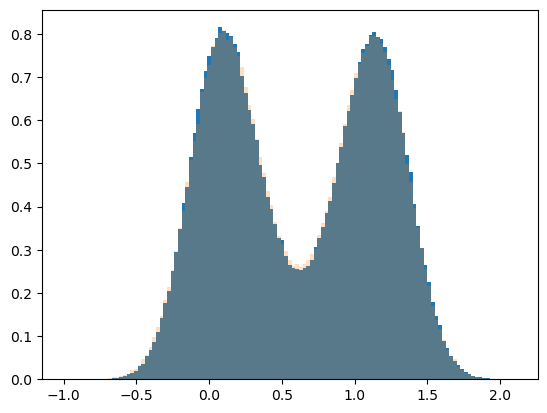

In [110]:
bin_edges = np.histogram_bin_edges(val_x, bins='fd')
vals, bin_edges = jnp.histogram(val_x, bins=bin_edges, density=True)
plt.bar(bin_edges[:-1], width=np.diff(bin_edges), height=vals, align='edge')

vals, bin_edges = jnp.histogram(preds, bins=bin_edges, density=True)
plt.bar(bin_edges[:-1], width=np.diff(bin_edges), height=vals, align='edge', alpha=0.25)

# Putting it all together

## Setup

### CombinedModel

In [700]:
@dataclasses.dataclass
class CombinedModel(nnx.Module):
    prior: nnx.Module
    forward: nnx.Module
    backward: nnx.Module

    def importance_weight(self, x):
        s = jnp.empty_like(x)
        logq_s, preds = self.backward(s, x)
        logp_s = self.prior(preds)
        logp_x_given_s = self.forward(preds, x)
        return logp_s + logp_x_given_s - logq_s
    
    def elbo(self, x, num_samples=1):
        inner = lambda mod: mod.importance_weight(x)
        return nnx.vmap(inner, state_axes={}, out_axes=1, axis_size=num_samples)(self)

    @nnx.jit
    def conditional_probability(self, s, x):
        return self.forward(s, x)

    @nnx.jit
    def marginal_probability(self, x, N=2**14):
        x = jnp.reshape(x, (-1, x.shape[-1]))
        
        def log_p(carry, mod, x):
            log_weights = mod.elbo(x, num_samples=N)
            ess = 1 / jnp.sum(jax.nn.softmax(log_weights, axis=1)**2) / N
            logp = jax.nn.logsumexp(log_weights, axis=1) - jnp.log(N)
            return None, (logp, ess)

        _, (logp, ess) = nnx.scan(log_p, state_axes={})(None, self, x)
        return jnp.squeeze(logp, 1), ess

### Trainer

In [701]:
import optax
from clu import metrics

class TrainerModule:
    def __init__(self, model, s, x, logdir):
        self.s = s
        self.x = x
        self.model = model
        self.logdir = logdir
        self.create_functions()

    @staticmethod
    def forward_loss(model, s, x):
        loss = -model(s, x)
        return jnp.mean(loss), {'loss': loss}

    @staticmethod
    def backward_loss(model, x, subsample=1):
        elbo = model.elbo(x, num_samples=subsample)
        loss = -jnp.mean(elbo)
        return loss, {'elbo': elbo}

    def create_functions(self):
        def train_step_forward(model, optimizer, s_batch, x_batch):
            grad_fn = nnx.value_and_grad(self.forward_loss, has_aux=True)
            (loss, metrics), grads = grad_fn(model, s_batch, x_batch)
            optimizer.update(grads=grads)
            return loss, metrics
        self.train_step_forward = nnx.jit(train_step_forward)

        def train_step_backward(model, optimizer, x, subsample=1):
            grad_fn = nnx.value_and_grad(self.backward_loss, has_aux=True, wrt=optimizer.wrt)
            (loss, metrics), grads = grad_fn(model, x, subsample)
            optimizer.update(grads=grads)
            return loss, metrics
        self.train_step_backward = nnx.jit(train_step_backward, static_argnames='subsample')

    def train_forward_model(self, key, num_steps=500, batch_size=64, learning_rate=1e-2):
        num_samples = self.s.shape[0]
        schedule = optax.cosine_decay_schedule(learning_rate, num_steps *  len(range(0, num_samples, batch_size)), alpha=0.1)
        optimizer = nnx.Optimizer(self.model.forward, optax.adamw(schedule))

        AverageLoss = metrics.Average.from_output('loss')
        writer = metric_writers.create_default_writer(os.path.join(self.logdir, 'Forward'))

        for epoch in range(num_steps):
            epoch_key = random.fold_in(key, epoch)
            perm = random.permutation(epoch_key, num_samples)
            s_shuffle = self.s[perm]
            x_shuffle = self.x[perm]

            average_loss = AverageLoss.empty()
            for j in range(0, num_samples, batch_size):
                s_batch = s_shuffle[j:j+batch_size]
                x_batch = x_shuffle[j:j+batch_size]
                loss, train_metrics = self.train_step_forward(self.model.forward, optimizer, s_batch, x_batch)
                average_loss = average_loss.merge(AverageLoss.from_model_output(loss=train_metrics['loss']))
            scalars = {'loss': average_loss.compute(), 'learning rate': schedule(optimizer.step.value)}
            writer.write_scalars(epoch + 1, scalars)

    def train_backward_model(self, key, num_steps=500, batch_size=64, subsample=16, learning_rate=5e-3):
        num_samples = self.x.shape[0]
        
        # only optimize parameters of backward model
        backward_filter = nnx.All(nnx.Param, lambda path, val: 'backward' in path)

        schedule = optax.exponential_decay(learning_rate, num_steps *  len(range(0, num_samples, batch_size)), 0.5)
        
        optimizer = nnx.Optimizer(self.model, optax.adamw(schedule), backward_filter)

        AverageLoss = metrics.Average.from_output('loss')
        writer = metric_writers.create_default_writer(os.path.join(self.logdir, 'Backward'))

        for epoch in range(num_steps):
            epoch_key = random.fold_in(key, epoch)
            perm = random.permutation(epoch_key, num_samples)
            x_shuffle = self.x[perm]

            average_loss = AverageLoss.empty()
            for j in range(0, num_samples, batch_size):
                x_batch = x_shuffle[j:j+batch_size]
                loss, train_metrics = self.train_step_backward(self.model, optimizer, x_batch, subsample=subsample)
                average_loss = average_loss.merge(AverageLoss.from_model_output(loss=-train_metrics['elbo']))
            scalars = {'loss': average_loss.compute(), 'learning rate': schedule(optimizer.step.value)}
            writer.write_scalars(epoch + 1, scalars)
            # writer.write_histograms(epoch + 1, metrics)

    def mutual_information(self, sample_size=1000):
        _, s = self.model.prior(jnp.empty((sample_size, 50)), generate=True)
        _, x = self.model.forward(s, jnp.empty_like(s), generate=True)

        cond = self.model.conditional_probability(s, x)
        marg, ess = self.model.marginal_probability(x)

        return jnp.mean(cond - marg), jnp.mean(ess)
        

In [ ]:
comb_model = CombinedModel(
    prior=InputModel(rngs=nnx.Rngs(1)),
    forward = ConvolutionalAutoregressiveModel(1, 16, 8, rngs=nnx.Rngs(2)),
    # forward = Sequence(64, rngs=nnx.Rngs(2)),
    # forward = LogisticModel(gain=20.0, decay=0.2, noise=0.2, rngs=nnx.Rngs(x_key)),
    backward= VariationalRnn(64, rngs=nnx.Rngs(3))
)

trainer = TrainerModule(comb_model, epsilon, x, os.path.join(logdir, 'trainer_adamw'))

In [703]:
trainer.train_forward_model(key, 500, batch_size=64, learning_rate=1e-2)

In [704]:
trainer.train_backward_model(key, 1000, batch_size=1024)

In [705]:
trainer.mutual_information()

(Array(0.05139148, dtype=float32), Array(0.11718282, dtype=float32))

In [ ]:
var_model = trainer.model.forward
variational_model = trainer.model.backward

### Data Management

We save our results in a simple DuckDB database.

In [1]:
import duckdb
import pandas as pd

In [2]:
con = duckdb.connect("../data/03-nonlinear.db")

In [3]:
def model_table(model):
    table = []
    for path, val in nnx.iter_graph(model):
        if type(val) in (int, bool, str, float):
            table.append({'param': '/'.join(map(str, path)), 'value': val})
    return pd.DataFrame(table)

## MI as a function of gain

In [ ]:
from datetime import datetime

gain = jnp.logspace(jnp.log10(0.025), jnp.log10(20), 20)

timestamp = datetime.now()
sample_size = 1_000
n_steps = 50
decay = 0.2
noise = 0.2

comb_model = CombinedModel(
    prior=InputModel(rngs=nnx.Rngs(1)),
    forward=logistic_model,
    # forward = ConvolutionalAutoregressiveModel(1, 16, 8, rngs=nnx.Rngs(2)),
    # forward = Sequence(64, rngs=nnx.Rngs(2)),
    backward= VariationalRnn(64, rngs=nnx.Rngs(3))
)
run_data = model_table(comb_model)
run_data = pd.concat((
    run_data,
    pd.DataFrame.from_dict({'param': ['sample_size', 'length', 'decay', 'noise'], 
                            'value': [sample_size, n_steps, decay, noise]})
))
run_data['timestamp'] = timestamp
con.sql('INSERT INTO RunData SELECT * FROM run_data')

data = []
for g in gain:
    s_key, x_key = random.split(random.fold_in(key, g))
    input_model = InputModel(rngs=nnx.Rngs(s_key))
    output_model = LogisticModel(gain=g, decay=decay, noise=noise, rngs=nnx.Rngs(x_key))
    _, epsilon = input_model(jnp.empty((sample_size, n_steps)), generate=True)
    _, x = output_model(epsilon, jnp.empty_like(epsilon), generate=True)

    comb_model.forward = output_model
    trainer = TrainerModule(comb_model, epsilon, x, os.path.join(logdir, timestamp.strftime('%Y-%m-%d_%H-%M-%S'), f"gain={g}"))
    # trainer.train_forward_model(x_key, 100)
    trainer.train_backward_model(s_key, 100)
    
    cond = trainer.model.conditional_probability(epsilon, x)    
    marg, ess = trainer.model.marginal_probability(x)
    data.append({
        'timestamp': timestamp,
        'gain': g.item(),
        'conditional_entropy': -jnp.mean(cond).item(), 
        'marginal_entropy': -jnp.mean(marg).item(), 
        'mutual_information': (jnp.mean(cond) - jnp.mean(marg)).item(),
        'ESS': jnp.mean(ess).item()
    })
    
    print("GAIN:", g)
    print("ESS: ", jnp.mean(ess))
    print("MI:  ", jnp.mean(cond) - jnp.mean(marg))

df = pd.DataFrame(data)
con.sql('CREATE TABLE IF NOT EXISTS RunResults AS FROM df LIMIT 0')
con.sql('INSERT INTO RunResults BY NAME (SELECT * FROM df)')

GAIN: 0.025000002
ESS:  0.96686715
MI:   0.022854805
GAIN: 0.03554137
ESS:  0.970965
MI:   0.05187702
GAIN: 0.05052757
ESS:  0.9790967
MI:   0.11277485
GAIN: 0.071832776
ESS:  0.99238074
MI:   0.23812962
GAIN: 0.10212144
ESS:  0.98855746
MI:   0.49193764
GAIN: 0.14518143
ESS:  0.9906474
MI:   0.9941244
GAIN: 0.20639789
ESS:  0.98736215
MI:   1.9525375
GAIN: 0.2934266
ESS:  0.99135244
MI:   3.6787243
GAIN: 0.41715136
ESS:  0.97872615
MI:   6.52693
GAIN: 0.5930453
ESS:  0.9889775
MI:   10.698744
GAIN: 0.84310585
ESS:  0.9655266
MI:   15.977343
GAIN: 1.1986058
ESS:  0.9752092
MI:   21.698128
GAIN: 1.7040035
ESS:  0.9606823
MI:   26.733727
GAIN: 2.4225051
ESS:  0.92793036
MI:   30.197044
GAIN: 3.4439666
ESS:  0.9218709
MI:   32.464497
GAIN: 4.896133
ESS:  0.9079218
MI:   33.62786
GAIN: 6.9606104
ESS:  0.843157
MI:   33.58885
GAIN: 9.895585
ESS:  0.8397432
MI:   33.2948
GAIN: 14.068111
ESS:  0.8546939
MI:   33.099804
GAIN: 19.999996
ESS:  0.850996
MI:   32.539204


ConversionException: Conversion Error: Unimplemented type for cast (TIMESTAMP_NS -> DOUBLE)

## Gaussian estimate

In [7]:
def table_names(con):
    return con.execute("SELECT table_name FROM information_schema.tables").fetchnumpy()["table_name"]

In [ ]:
gaussian_gain = jnp.logspace(jnp.log10(0.025), jnp.log10(20), 200)
sample_size = 1_000
n_steps = 50
decay = 0.2
noise = 0.2
key = random.key(1)

def gaussian_mi_for_gain(g, sample_size, length):
    s_key, x_key = random.split(random.fold_in(key, g))
    _, s = InputModel()(jnp.empty((sample_size, length)), generate=True, rngs=nnx.Rngs(s_key))
    x_model = LogisticModel(gain=g, decay=decay, noise=noise, rngs=nnx.Rngs(x_key))
    _, x = x_model(s, jnp.zeros_like(s), generate=True)
    return gaussian_mi(s, x)

def gaussian_mi_data(gain_values, sample_size=1_000, length=50):
    f = lambda g: gaussian_mi_for_gain(g, sample_size, length)
    gaussian_mutual_info = jax.lax.map(f, gain_values)
    return pd.DataFrame({
        'gain': gain_values, 
        'mutual information': gaussian_mutual_info, 
        'sample_size': sample_size, 
        'decay': decay, 
        'noise': noise, 
        'length': length
    })

if "GaussianData" not in table_names(con):
    gaussian_data = pd.concat((
        gaussian_mi_data(gaussian_gain, sample_size=1_000),
        gaussian_mi_data(gaussian_gain, sample_size=100_000)
    ))
    con.sql('CREATE OR REPLACE TABLE GaussianData AS FROM gaussian_data')

con.sql('SELECT * FROM GaussianData')

┌─────────────┬────────────────────┬─────────────┬────────┬────────┬────────┐
│    gain     │ mutual information │ sample_size │ decay  │ noise  │ length │
│    float    │       float        │    int64    │ double │ double │ int64  │
├─────────────┼────────────────────┼─────────────┼────────┼────────┼────────┤
│ 0.025000002 │          1.3266144 │        1000 │    0.2 │    0.2 │     50 │
│  0.03554137 │           1.355423 │        1000 │    0.2 │    0.2 │     50 │
│  0.05052757 │          1.4159088 │        1000 │    0.2 │    0.2 │     50 │
│ 0.071832776 │          1.5406876 │        1000 │    0.2 │    0.2 │     50 │
│  0.10212144 │          1.7936707 │        1000 │    0.2 │    0.2 │     50 │
│  0.14518143 │          2.2946777 │        1000 │    0.2 │    0.2 │     50 │
│  0.20639789 │          3.2517624 │        1000 │    0.2 │    0.2 │     50 │
│   0.2934266 │          4.9759064 │        1000 │    0.2 │    0.2 │     50 │
│  0.41715136 │          7.8134003 │        1000 │    0.2 │    0

## Plot Data

First we get the relevant data from the database.

In [4]:
def run_at_time(con, time: str):
    return con.sql(f"SELECT * FROM RunResults WHERE strftime(timestamp, '%Y-%m-%d_%H-%M-%S') = '{time}'")

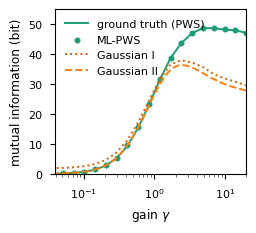

In [85]:
plt.style.use('seaborn-v0_8-paper')
def plot_gain_results(con):
    cnn_result = run_at_time(con, "2024-06-25_17-37-53").df()
    analytical_result = run_at_time(con, "2024-06-26_11-43-38").df()
    gaussian_result_large = con.sql('SELECT * FROM GaussianData WHERE sample_size = 100000').df()
    gaussian_result_small = con.sql('SELECT * FROM GaussianData WHERE sample_size = 1000').df()

    # width = 27/8
    # width=5
    width = 176 / 72
    height = 160 / 72
    with plt.rc_context({'font.size': 8, 'lines.markersize': 4}):
        fig, ax = plt.subplots(figsize=(width, height), constrained_layout=True)
        colors = plt.get_cmap('Dark2').colors
        ax.set_prop_cycle(plt.cycler(color=colors))
        ax.plot(analytical_result.gain, analytical_result['mutual_information'] / np.log(2), label='ground truth (PWS)')
        ax.scatter(cnn_result.gain, cnn_result['mutual_information'] / np.log(2), label='ML-PWS')
        ax.plot(gaussian_result_small.gain, gaussian_result_small['mutual information'] / np.log(2), label='Gaussian I', ls=':')
        ax.plot(gaussian_result_large.gain, gaussian_result_large['mutual information'] / np.log(2), label='Gaussian II', ls='--', color='C1')
        ax.set_xlabel('gain $\\gamma$')
        ax.set_ylabel('mutual information (bit)')
        ax.set_xscale('log')
        ax.set_ylim(0, 38 / np.log(2))
        ax.set_xlim(10**-1.4, 20)
        # ax.grid()
        ax.legend(loc='upper left', frameon=False)
    return fig
    
fig = plot_gain_results(con)
fig.savefig('../reports/figures/MI_gain_bits.pdf')

fig